In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from dynamics_env.dynamics_rocket import Dynamics

In [2]:
destination_type = 'radius'
orbit_duration = 1 * 86400 * 365
orbit_timesteps = 1000
device = 'cpu'
seed = 0
rocket_mass = 433100
start = None
destination_type = 'radius'
destination_params = None
v_e = 3500
fuel_frac = 0.9
dry_mass = rocket_mass * (1 - fuel_frac)
capture_radius = 6371e2

In [3]:
def make_env(seed):
    def thunk():
        env = Dynamics(hyperparameters={
            'planetary_model_list':['point_source', 'point_source', 'point_source'],
            'planetary_model_kwargs_list':[{'M':2e30, 'period':1e10, 'orbit_radius':0, 'phase':0}, # sun
                                            {'M':2e30, 'period':11.86, 'orbit_radius':7.7866e11, 'phase':0.785}, # jupiter
                                            {'M':2e30, 'period':1, 'orbit_radius':1.496e11, 'phase':3.945}], # earth
            'seed':seed,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk
    
env = make_env(seed=seed)()

In [4]:
if start == None:
    leo_distance = 300e3 # 300e3 m
    leo_speed = 7.7e3 # 7.7e3 m/s
    launch_theta = np.random.rand() * 2 * np.pi
    earth_phase, earth_orbit_radius = env.planetary_models[-1].phase, env.planetary_models[-1].orbit_radius
    launch_position = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
    launch_velocity = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_speed
    # launch_acc = env.get_acceleration(np.concat([launch_position, np.array([0])]))
    launch_mass = np.array([rocket_mass])
    init_params = np.concat([launch_position, launch_velocity, launch_mass])
else: init_params = np.array(start)
if destination_type == 'radius':
    if destination_params == None:
        destination_radius = 35768e3 # geocentric orbit radius
        start_center = np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
    else:
        destination_radius = destination_params[0]
        start_center = destination_params[1]
elif destination_type == 'destination_planet':
    if destination_params == None:
        destination_planet_index = len(env.planetary_models)-1
        destination_planet_radius = 6051.8e3 # m (venus)
    else:
        destination_planet_index = destination_params[0]
        destination_planet_radius = destination_params[1]
    start_planet_distance = np.linalg.norm(init_params[:2] - env.planetary_models[destination_planet_index].get_position())
elif destination_type == 'destination':
    if destination_params == None:
        destination_distance = 3 * 1.496e11 # 3au in m
        destination_theta = np.random.rand() * 2 * np.pi # in rad
        destination_radius = 6371e3 # earth radius in m
    else:
        destination_distance = destination_params[0]
        destination_theta = destination_params[1]
        destination_radius = destination_params[2]
    start_destination_distance = np.linalg.norm(init_params[:2] - np.linalg.norm(np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance))
    destination_coords = np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius

In [5]:
def event_dest_reached(t, y):
    pos = y[:2]
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center)
        completion = 1 if current_radius >= destination_radius else 0
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        completion = 1 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 0
    elif destination_type == 'destination':
        completion = 1 if np.linalg.norm(pos - destination_coords) < destination_radius else 0
    return completion
event_dest_reached.terminal = True
def rocket_captured(t, y):
    pos = y[:2]
    min_dist = np.inf
    for model in env.planetary_models:
        dist = np.linalg.norm(pos - model.get_position(t))
        print(dist)
        min_dist = min(min_dist, dist)
    return min_dist - capture_radius
rocket_captured.terminal = True
# rocket_captured.direction = -1

rewards = np.zeros((orbit_timesteps,))
def rocket_function(t, y):
    # state packaging
    episode_step = int(t//orbit_duration)
    pos = y[:2]
    vel = y[2:4]
    mass = y[4:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # action sampling
    action_mag = 0
    action = env._process_actions(action_mag * np.array([np.cos(0), np.sin(0)]))
    reward, done = reward_function(pos, mass, 0 if t == 0 else rewards[episode_step-1])
    # rocket science
    rewards[episode_step] = reward.item()
    thrust = action # in N (kg m/s^2)
    mdot = np.linalg.norm(thrust, axis=-1) / v_e # in m/s^2
    delta_m = mdot * orbit_duration / orbit_timesteps
    if (mass - delta_m) < dry_mass:
        a_thrust = np.zeros_like(thrust)
        mdot = 0
    else:
        a_thrust = thrust / mass

    # derivatives for integrator
    dydt = np.zeros_like(y)
    dydt[:2] = vel
    dydt[2:4] = a_gravity + a_thrust
    dydt[4] = mdot
    return dydt

def reward_function(pos, mass, previous_reward):
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center)
        consistent_reward = current_radius / destination_radius + (1 - mass / rocket_mass)
        completion_reward = 10 if current_radius >= destination_radius else 0
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        consistent_reward = np.linalg.norm(planet_position - pos) / start_planet_distance + (1 - mass / rocket_mass)
        completion_reward = 10 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 0
    elif destination_type == 'destination':
        consistent_reward = np.linalg.norm(destination_coords - pos) / start_destination_distance + (1 - mass / rocket_mass)
        completion_reward = 10 if np.linalg.norm(pos - destination_coords) < destination_radius else 0
    return consistent_reward + completion_reward - previous_reward, completion_reward > 0

In [6]:
orbit = solve_ivp(rocket_function, t_span=(0, orbit_duration), y0=init_params, t_eval=np.linspace(0, orbit_duration, orbit_timesteps), events=rocket_captured)

149600192344.43082
928238936284.9429
300000.0000065301
149600192344.43927
928238936284.9517
300000.2010105589
149600192340.99988
928238936281.4524
299996.7142708433
149600191953.94162
928238935887.3191
299411.7823688818
149600165214.40817
928238908656.9155
257845.59350835838
149600148910.4155
928238892053.4557
232448.5120010762
149600127325.0012
928238870071.4609
198807.03953934403
149600080520.89993
928238822407.0428
125816.08166539123
149600052124.01175
928238793487.8411
81502.96283232812
149600041898.65402
928238783074.3082
65539.87677602033
149600029743.40976
928238770695.2714
46557.76795397864
149600014649.46094
928238755323.1611
22971.481733133387
149600009038.8915
928238749609.0425
14195.94646443156
149600007022.56006
928238747555.4551
11039.985748544957
149600004644.04745
928238745132.9437
7314.538771533068
149600003218.59586
928238743681.08
5079.652310720113
149600001776.5864
928238742212.2874
2815.552783594821
149600000901.13266
928238741320.5037
1437.5203065201324
1496000004

In [7]:
orbit

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00]
        y: [[-1.039e+11]
            [-1.077e+11]
            [-7.680e+03]
            [ 5.493e+02]
            [ 4.331e+05]]
      sol: None
 t_events: [array([ 1.635e-02])]
 y_events: [array([[-1.039e+11, -1.077e+11, -1.195e+09,  1.142e+07,
                    4.331e+05]])]
     nfev: 578
     njev: 0
      nlu: 0

IndexError: index 1 is out of bounds for axis 1 with size 1

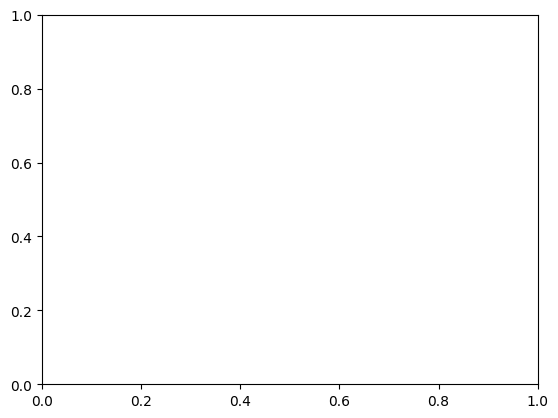

In [8]:
plot, axes = plt.subplots(1,1)
axes.plot(orbit.y[:,0], orbit.y[:,1], label='rocket')
jupiter_orbit = env.planetary_models[1].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps))
axes.plot(jupiter_orbit[0], jupiter_orbit[1], label='jupiter')
earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps))
axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
axes.legend()

In [ ]:
jupiter_orbit

array([[5.50814950e+11, 5.50523002e+11, 5.50230900e+11, ...,
        1.97978273e+11, 1.97578884e+11, 1.97179440e+11],
       [5.50376496e+11, 5.50668521e+11, 5.50960391e+11, ...,
        7.53071045e+11, 7.53175929e+11, 7.53280601e+11]])

1218965463.7146862


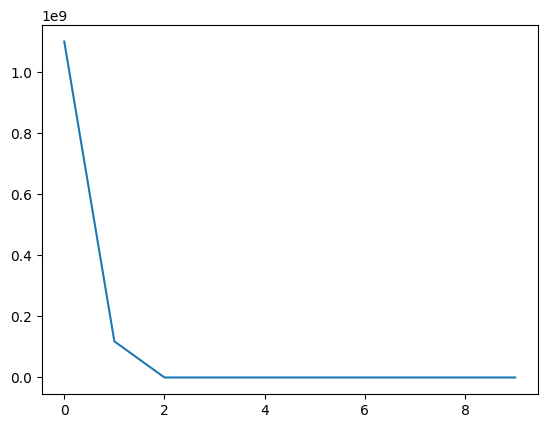

In [ ]:
plt.plot(rewards[:10])
print(rewards.sum())